## Part 1: Pulse Rate Algorithm

### Overview

This project has 2 main parts.
	1. Develop a Pulse Rate Algorithm on the given training data. Then Test Your Algorithm and see that it has met the success criteria.
	2. Apply the Pulse Rate Algorithm on a Clinical Application and compute more clinically meaningful features and discover healthcare trends.
    
### Introduction

A core feature that many users expect from their wearable devices is pulse rate estimation. Continuous pulse rate estimation can be informative for many aspects of a wearer's health. Pulse rate during exercise can be a measure of workout intensity and resting heart rate is sometimes used as an overall measure of cardiovascular fitness. In this part of the project, a pulse rate estimation algorithm for a wrist-wearable device was created and evaluated. 

### Dataset

The **Troika**[1] dataset are used to build puls rate estimation algorithm. Find the dataset under `datasets/troika/training_data`. The `README` in that folder will tell you how to interpret the data. 

1. Zhilin Zhang, Zhouyue Pi, Benyuan Liu, ‘‘TROIKA: A General Framework for Heart Rate Monitoring Using Wrist-Type Photoplethysmographic Signals During Intensive Physical Exercise,’’IEEE Trans. on Biomedical Engineering, vol. 62, no. 2, pp. 522-531, February 2015. Link

-----

### Code

In [1]:
#! pip install mpld3

In [2]:
import glob

import numpy as np
import scipy as sp
import scipy.io
import scipy.signal
import scipy.stats

from matplotlib import pyplot as plt
import mpld3
%matplotlib inline
mpld3.enable_notebook()

In [3]:
def LoadTroikaDataset():
    """
    Retrieve the .mat filenames for the troika dataset.

    Review the README in ./datasets/troika/ to understand the organization of the .mat files.

    Returns:
        data_fls: Names of the .mat files that contain signal data
        ref_fls: Names of the .mat files that contain reference data
        <data_fls> and <ref_fls> are ordered correspondingly, so that ref_fls[5] is the 
            reference data for data_fls[5], etc...
    """
    data_dir = "./datasets/troika/training_data"
    data_fls = sorted(glob.glob(data_dir + "/DATA_*.mat"))
    ref_fls = sorted(glob.glob(data_dir + "/REF_*.mat"))
    return data_fls, ref_fls

def LoadTroikaDataFile(data_fl):
    """
    Loads and extracts signals from a troika data file.

    Usage:
        data_fls, ref_fls = LoadTroikaDataset()
        ppg, accx, accy, accz = LoadTroikaDataFile(data_fls[0])

    Args:
        data_fl: (str) filepath to a troika .mat file.

    Returns:
        numpy arrays for ppg, accx, accy, accz signals.
    """
    data = sp.io.loadmat(data_fl)['sig']
    return data[2:]

def AggregateErrorMetric(pr_errors, confidence_est):
    """
    Computes an aggregate error metric based on confidence estimates.

    Computes the MAE at 90% availability. 

    Args:
        pr_errors: a numpy array of errors between pulse rate estimates and corresponding 
            reference heart rates.
        confidence_est: a numpy array of confidence estimates for each pulse rate
            error.

    Returns:
        the MAE at 90% availability
    """
    # Higher confidence means a better estimate. The best 90% of the estimates
    #    are above the 10th percentile confidence.
    percentile90_confidence = np.percentile(confidence_est, 10)

    # Find the errors of the best pulse rate estimates
    best_estimates = pr_errors[confidence_est >= percentile90_confidence]

    # Return the mean absolute error
    return np.mean(np.abs(best_estimates))

def Evaluate():
    """
    Top-level function evaluation function.

    Runs the pulse rate algorithm on the Troika dataset and returns an aggregate error metric.

    Returns:
        Pulse rate error on the Troika dataset. See AggregateErrorMetric.
    """
    # Retrieve dataset files
    data_fls, ref_fls = LoadTroikaDataset()
    errs, confs = [], []
    for data_fl, ref_fl in zip(data_fls, ref_fls):
        # Run the pulse rate algorithm on each trial in the dataset
        errors, confidence = RunPulseRateAlgorithm(data_fl, ref_fl)
        errs.append(errors)
        confs.append(confidence)
        # Compute aggregate error metric
    errs = np.hstack(errs)
    confs = np.hstack(confs)
    return AggregateErrorMetric(errs, confs)

def BandpassFilter(signal, lowcut=40./60, highcut=240./60, fs=125):
    """
    Loads the signal and passes it through a Butterworth bandpass filter.
    Args:
        signal: array_like, signal data to be filtered
        lowcat: float, low cut frequency in Hz
        highcut: float, high cut frequency in Hz
        fs: float, the sampling frequency of the digital system in Hz
    Returns:
        array_like, Band Pass filtered Signal
    """
    # Initiate bandpass filter
    b, a = sp.signal.butter(3, (lowcut, highcut), btype='bandpass', fs=fs)
    # Apply Butterworth bandpass filter and return filtered signal
    return sp.signal.filtfilt(b, a, signal)

def FourierTransform(signal, fs=125, zerofill=2):
    """
    Loads the signal and do a Discrete Fourier Transform on the signal
    Args:
        signal: array_like, signal data to apply Discrete Fourier Transform 
        fs: float, the sampling frequency of the digital system in Hz
        zerofill: int, zero fill spectrum
    Returns:
        array_like, frequency and magnitude of the signal
    """
    # Compute discrete Fourier Transform sample frequencies
    fftlen = len(signal) * zerofill # for zero padding
    freqs = np.fft.rfftfreq(fftlen, 1/fs)
    # Compute the one-dimensional discrete Fourier Transform for real input
    fft = np.abs(np.fft.rfft(signal, fftlen))
    return freqs, fft

def spectrogram_show(signal, fs, signal_name, ylimits=(0.5, 5.5), estimates=None):
    '''
    Plot spectrogram with or without estimates
    Args:
        signal: array_like, signal data to apply Discrete Fourier Transform 
        fs: float, the sampling frequency of the digital system in Hz
        signal_name: string, name of the signal to show on the image
        ylimits: tuple, (0.5, 5.5) is default
        estimates: None or array, the estimated frequencies
    Returns:
        Plot spectrogram   
    '''
    plt.figure(figsize=(12, 8))
    spec, freqs, t, _ = plt.specgram(signal, NFFT=fs*4, Fs=fs, noverlap=0);
    plt.xlabel('Time (sec)')
    plt.ylabel('Frequency (Hz)')
    plt.ylim(ylimits)
    if not (estimates is None):
        plt.hlines(estimates, 0, len(signal)/fs, 'k')
        plt.title(f'{signal_name} Signal Spectrogram with estimates')
    else:
        plt.title(f'{signal_name} Signal Spectrogram')
    plt.show()

def signal_fft_show(signal, fs, xlimits=(0, 10), ylimits=None, peaks=None):
    '''
    Plot signal and FFT with or without estimates
    Args:
        signal: array_like, signal data to apply Discrete Fourier Transform 
        fs: float, the sampling frequency of the digital system in Hz
        xlimits: tuple, (0, 10) is default
        ylimits: tuple, None is default
        peaks: None or array, the estimated frequencies
    Returns:
        Plot signal and it's FFT   
    '''
    freqs, fft = FourierTransform(signal, fs=fs)
    # smooth FFT with Savitzky–Golay filter
    fft = scipy.signal.savgol_filter(fft, 5, 2)
    ts = np.arange(0, len(signal)/fs, 1/fs)
    plt.figure(figsize=(12, 8))
    plt.subplot(2,1,1)
    plt.plot(ts, signal)
    plt.title('Time-Domain')
    plt.xlabel('Time (sec)')
    plt.subplot(2,1,2)
    plt.plot(freqs, fft)
    if not (peaks is None):
        plt.plot(freqs[peaks], fft[peaks], 'r.', ms=10)
    plt.title('Frequency-Domain')
    plt.xlabel('Frequency (Hz)')
    plt.tight_layout()
    plt.xlim(xlimits)
    if ylimits:
        plt.ylim(ylimits)
    plt.show()
    
def plot_signal_fft_spectrogram_estimates(signal, fs, signal_name, threshold, distance, freqs_limits=(0.5, 5.5)):
    '''
    Plot signal, FFT, and spectrogram with simple estimates
    Args:
        signal: array_like, signal data to apply Discrete Fourier Transform 
        fs: int, the sampling frequency of the digital system in Hz
        signal_name: string, name of the signal to show on the image
        threshold: float, the Y cut base on max Y value
        distance: integer, min distance between peaks
        freqs_limits: tuple, (0.5, 5.5) is default
    Returns:
        Plot signal, it's FFT, spectrogram with simple estimates
        print out peak estimates and confidence ratio
    '''
    freqs, fft = FourierTransform(signal, fs=fs)
    # smooth FFT with Savitzky–Golay filter
    fft = scipy.signal.savgol_filter(fft, 3, 2)
    pks = sp.signal.find_peaks(fft, height=np.max(fft)*threshold, distance=distance)[0]
    estimates = freqs[pks]
    signal_fft_show(signal, fs, xlimits=freqs_limits, peaks=pks)
    spectrogram_show(signal, fs, signal_name, ylimits=freqs_limits, estimates=estimates)
    print('Peaks esstimates Hz:', estimates)
    print('Peaks esstimates Per/Min:', estimates*60)
    confidence = []
    for indx in range(len(pks)):
        pk_l = freqs[int(pks[indx] - 10)]
        pk_m = freqs[int(pks[indx] + 10)]
        fft_pk = fft[(freqs >= pk_l) & (freqs <= pk_m)]
        freqs_pk = freqs[(freqs >= pk_l) & (freqs <= pk_m)]
        plt.plot(freqs_pk, fft_pk)
        plt.show()
        pk_confidence = np.sum(fft[(freqs >= pk_l) & (freqs <= pk_m)] / np.sum(fft))
        confidence.append(pk_confidence) 
        print('Peak:', freqs[pks[indx]])
        print('Confidence (ratio area under peak / fft area): ', pk_confidence)
                               
    return estimates, pks, confidence 
 
def FindPeaks(signal, fs, threshold, distance, sg_filter=True):
    '''
    Find peaks in the spectrum and calculate confidence of the peaks defined as a ratio 
    of sum of the frequency spectrum near the pulse rate estimate and the sum of the entire spectrum.
    Args:
        signal: array_like, signal data to apply Discrete Fourier Transform 
        fs: int, the sampling frequency of the digital system in Hz
        threshold: float, the Y cut base on max Y value
        distance: integer, min distance between peaks
        sg_filte: True or False, applying Savitzky–Golay filter to smooth spectrum
    Return:
        estimates: list, peaks estimates in Hz 
        pks: list, peaks index in FFT spectrum
        confidence: list, confidence ratio
        freqs: array_like, frequencies 
        fft: array_like, fft 
    '''
    # Fourier transform
    freqs, fft = FourierTransform(signal, fs=fs, zerofill=2)
    
    # smooth FFT with Savitzky–Golay filter if set True
    if sg_filter:
        fft = scipy.signal.savgol_filter(fft, 5, 3)
    
    # get peaks
    pks = sp.signal.find_peaks(fft, height=np.max(fft)*threshold, distance=distance)[0]
    
    # compute peaks
    estimates = freqs[pks]
    
    # compute estimates
    confidence = []
    for indx in range(len(pks)):
        pk_l = freqs[int(pks[indx] - 10)]
        pk_m = freqs[int(pks[indx] + 10)]
        fft_pk = fft[(freqs >= pk_l) & (freqs <= pk_m)]
        freqs_pk = freqs[(freqs >= pk_l) & (freqs <= pk_m)]
        pk_confidence = np.sum(fft[(freqs >= pk_l) & (freqs <= pk_m)] / np.sum(fft))
        confidence.append(pk_confidence) 
                               
    return estimates, pks, confidence, freqs, fft    
    
def Estimates(ppg_bp, acc_bp, wind_length, wind_shift, fs):
    '''
    Estimate heart rate in BMP
    Args:
        ppg_bp: array_like, bandpassed signal data from photoplethysmography sensor 
        acc_bp: array_like, bandpassed magnitude signal data from accelerator sensor 
        wind_length: int, time frame in seconds to collect signal for BMP estimation
        wind_shift: int, time frame in seconds to output the BMP estimate
        fs: int, the sampling frequency of the digital system in Hz
    Return:
    Hear rate estimate in BMP and confidence
    '''
    estimate_bmp, confidence = [], []
    
    for indx in range(0, len(ppg_bp) - wind_length*fs, wind_shift*fs):
        ppg_wind = ppg_bp[indx:indx+wind_length*fs]
        acc_wind = acc_bp[indx:indx+wind_length*fs]
        
        # get potential estimates
        estimates_ppg, pks_ppg, confidence_ppg, freqs_ppg, fft_ppg = \
                                        FindPeaks(ppg_wind, fs, 0.3, 1, sg_filter=True)
        estimates_acc, pks_acc, confidence_acc, freqs_acc, fft_acc = \
                                        FindPeaks(acc_wind, fs, 0.3, 20, sg_filter=True)
        
        # create exclution indexes base on acc peaks
        exclude_acc = [list(range(tmp - 2, tmp + 3)) for tmp in pks_acc]
        exclude_acc_np = np.array(exclude_acc).flatten()
        
        # check that there is a ppg peak
        if len(estimates_ppg) == 0:
            estimate_bmp_tmp = freqs_ppg[np.argsort(fft_ppg, axis=0)[::-1][0]] * 60
            confidence_tmp = 0.0
        elif len(estimates_ppg) == 1:
            estimate_bmp_tmp = freqs_ppg[pks_ppg[0]] * 60
            confidence_tmp = confidence_ppg[0]           
        else:
            # sort peaks and check if acc peak is not overlapping with the ppg peaks 
            # the criteria is, the acc peak shouldn be within FWHM of the acc peaks
            estimate_ppg_indx = []
            pks_ppg_sorted = np.argsort(fft_ppg[pks_ppg], axis=0)[::-1]
            #pks_acc_sorted = np.argsort(fft_acc[pks_acc], axis=0)[::-1]            
            for indx_pks in pks_ppg_sorted:
                #for fft_max_acc in pks_acc_sorted:
                if (pks_ppg[indx_pks] not in exclude_acc_np): #& (indx_pks not in estimate_ppg_indx):
                    estimate_ppg_indx.append(indx_pks)
            if len(estimate_ppg_indx) == 0:
                estimate_ppg_indx = pks_ppg_sorted
            estimate_bmp_tmp = freqs_ppg[pks_ppg[estimate_ppg_indx[0]]] * 60
            confidence_tmp = confidence_ppg[estimate_ppg_indx[0]]      
        
        # in case of BMP jumps more than 20 BMP from previous 2 sec, 
        # the BMP and confidence will be computed as anaverage of the last 3 calculations 
        if len(estimate_bmp) > 1:
            if abs(estimate_bmp[-1] - estimate_bmp_tmp) >= 20:
                estimate_bmp_tmp = (estimate_bmp_tmp + estimate_bmp[-1] + estimate_bmp[-2])/3
                confidence_tmp = (confidence_tmp + confidence[-1] + confidence[-2])/3
        # add estimated BMP and Confidence to the list
        estimate_bmp.append(estimate_bmp_tmp)
        confidence.append(confidence_tmp)       
        
    return np.array(estimate_bmp), np.array(confidence)

def RunPulseRateAlgorithm(data_fl, ref_fl):
    # Set sampling rate and window lenght and shift 
    fs = 125
    wind_length = 8
    wind_shift = 2
    
    # Load data using LoadTroikaDataFile
    ppg, accx, accy, accz = LoadTroikaDataFile(data_fl)
    
    # Load ground truth 
    gt = sp.io.loadmat(ref_fl)['BPM0'].reshape(-1)
    
    # Bandpass signals
    ppg_bp = BandpassFilter(ppg)
    accx_bp = BandpassFilter(accx)
    accy_bp = BandpassFilter(accy)
    accz_bp = BandpassFilter(accz)
    
    # Combine x, y, z accelerator signals (magnitude)
    acc_bp = BandpassFilter(np.sqrt(np.square(accx_bp) + np.square(accx_bp) + np.square(accx_bp)))
    
    # Compute pulse rate estimates and estimation confidence.
    estimate_bmp, confidence = Estimates(ppg_bp, acc_bp, wind_length, wind_shift, fs)

    # Return per-estimate mean absolute error and confidence as a 2-tuple of numpy arrays.
    len_data = min(len(estimate_bmp), len(gt))
    errors = np.abs(estimate_bmp[:len_data] - gt[:len_data])

    return errors[:len_data], confidence[:len_data]

### Test functions and some parts of the algorithm

In [4]:
data_fls, ref_fls = LoadTroikaDataset()

In [5]:
fs = 125
wind_length = 8
wind_shift = 2
test_case_num = 0
data_fl = data_fls[test_case_num]
ref_fl = ref_fls[test_case_num]
ppg, accx, accy, accz = LoadTroikaDataFile(data_fl)
gt = sp.io.loadmat(ref_fl)['BPM0'].reshape(-1)

In [6]:
# bandpass signals
ppg_bp = BandpassFilter(ppg)
accx_bp = BandpassFilter(accx)
accy_bp = BandpassFilter(accy)
accz_bp = BandpassFilter(accz)
# combine x, y, z accelerator signals
acc_bp = BandpassFilter(np.sqrt(np.square(accx_bp) + np.square(accx_bp) + np.square(accx_bp)))

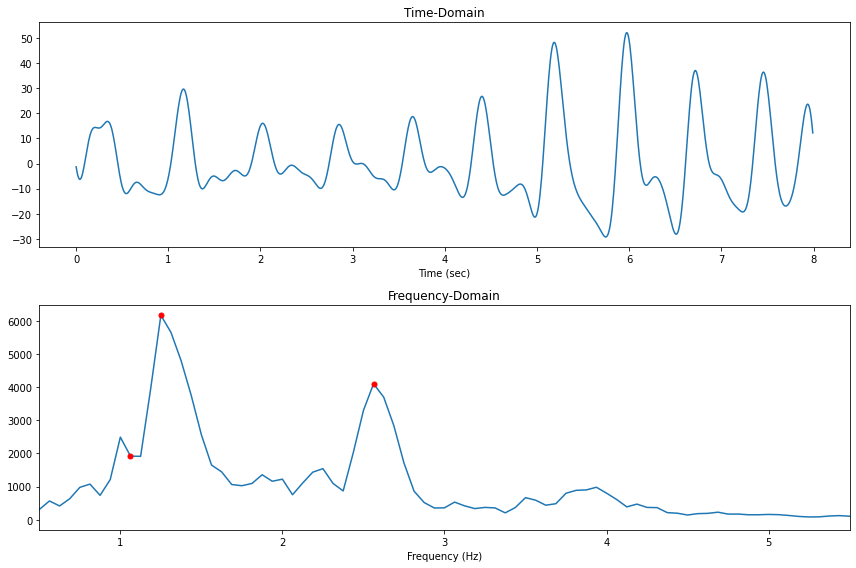

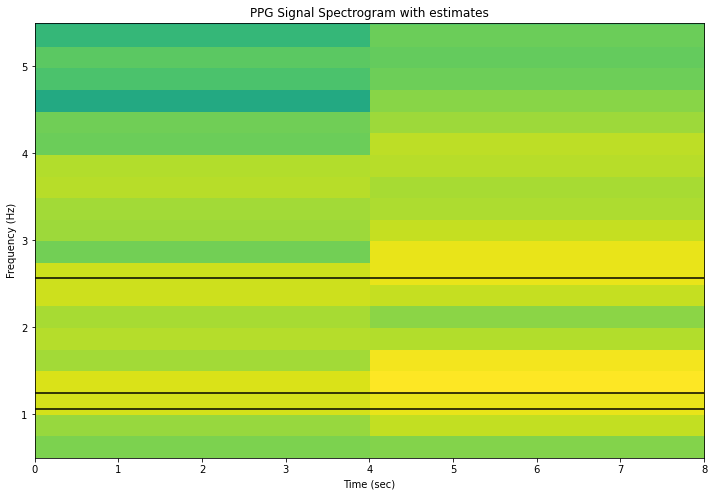

Peaks esstimates Hz: [1.0625 1.25   2.5625]
Peaks esstimates Per/Min: [ 63.75  75.   153.75]


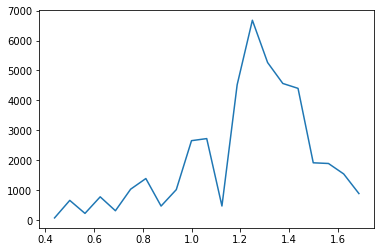

Peak: 1.0625
Confidence (ratio area under peak / fft area):  0.4194888828697774


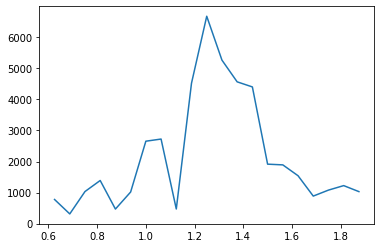

Peak: 1.25
Confidence (ratio area under peak / fft area):  0.4424444091820988


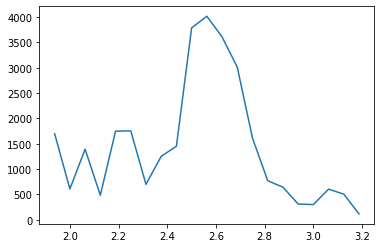

Peak: 2.5625
Confidence (ratio area under peak / fft area):  0.29284468946195713


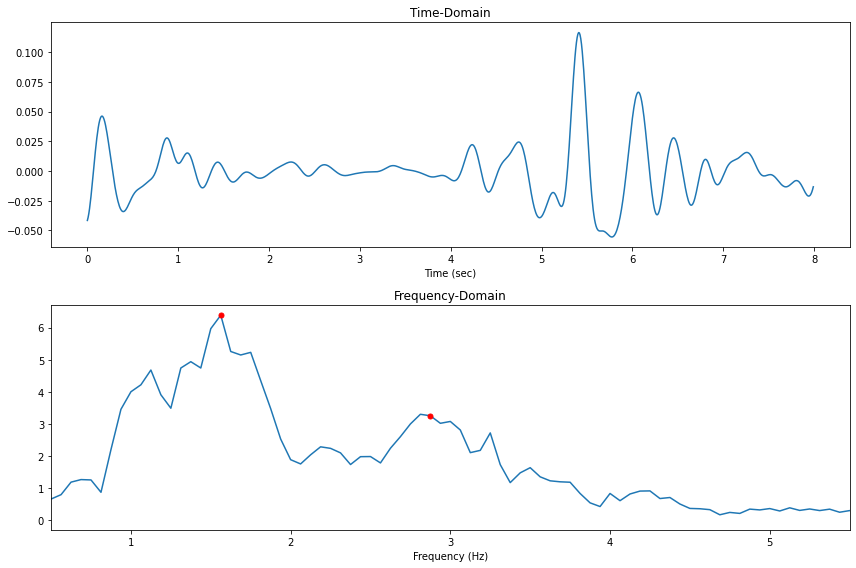

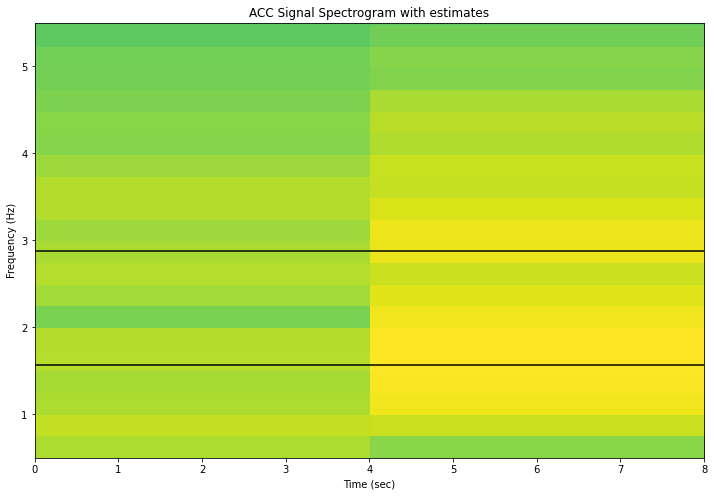

Peaks esstimates Hz: [1.5625 2.875 ]
Peaks esstimates Per/Min: [ 93.75 172.5 ]


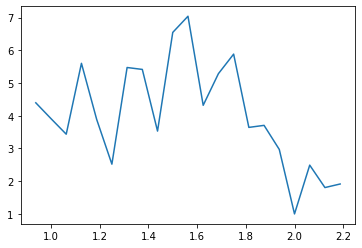

Peak: 1.5625
Confidence (ratio area under peak / fft area):  0.4201504847285181


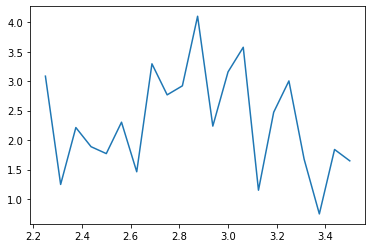

Peak: 2.875
Confidence (ratio area under peak / fft area):  0.24070868471125445


(array([1.5625, 2.875 ]),
 array([25, 46]),
 [0.4201504847285181, 0.24070868471125445])

In [7]:
# for the window wnum=1
wnum = 1
wind_start = wnum*2*fs 
plot_signal_fft_spectrogram_estimates(ppg_bp[wind_start:wind_start+wind_length*fs], fs, 'PPG', 0.3, 1)
plot_signal_fft_spectrogram_estimates(acc_bp[wind_start:wind_start+wind_length*fs], fs, 'ACC', 0.3, 20)

In [8]:
# for the window wnum=1
wnum = 1
wind_start = wnum*2*fs 
estimates_ppg, pks_ppg, confidence_ppg, freqs_ppg, fft_ppg = \
                            FindPeaks(ppg_bp[wind_start:wind_start+wind_length*fs], fs, 0.3, 1, sg_filter=True)
print(fft_ppg[pks_ppg])
print(estimates_ppg*60)
estimates_ppg, pks_ppg, confidence_ppg

[2491.39108832 6169.46228328 4102.82525494]
[ 60.    75.   153.75]


(array([1.    , 1.25  , 2.5625]),
 array([16, 20, 41]),
 [0.4137429193330289, 0.4429385184770313, 0.29189926674863187])

In [9]:
estimates_acc, pks_acc, confidence_acc, freqs_acc, fft_acc = \
                            FindPeaks(acc_bp[wind_start:wind_start+wind_length*fs], fs, 0.3, 20, sg_filter=True)
print(fft_acc[pks_acc])
print(estimates_acc*60)
estimates_acc, pks_acc, confidence_acc

[6.38919633 3.29999165]
[ 93.75 168.75]


(array([1.5625, 2.8125]),
 array([25, 45]),
 [0.418797296519445, 0.24172579064235045])

In [10]:
estimate_bmp, confidence = Estimates(ppg_bp, acc_bp, wind_length, wind_shift, fs)
total_mae = np.mean(np.abs(estimate_bmp - gt))
print(total_mae)

17.155472624361057


In [11]:
RunPulseRateAlgorithm(data_fl, ref_fl)

(array([71.91079295,  1.35746606,  1.60714286,  0.33185841,  1.33064516,
         0.43458781,  1.64416847,  1.55059848,  0.33482143,  1.8442623 ,
         0.8490566 ,  0.36392405,  0.49668874,  3.33825266,  2.08762887,
         0.69244604,  6.06958763,  9.04978587,  3.37707182,  1.01893096,
        16.59988713,  3.23529412, 19.87412716, 29.89852081, 35.63352827,
        39.5949802 , 41.91658805, 55.91986456, 54.65189873, 54.05172414,
        39.32539683, 35.79329461, 39.21610169, 53.44450374, 47.54084967,
        45.16675284, 43.08030647, 45.91657811, 45.20053476, 59.71804511,
        58.86363636, 57.99618321, 42.36842105, 32.72790055, 23.77647715,
        32.98194005, 44.80769231, 43.1148429 , 27.28305785, 22.13050314,
        14.15391913,  0.38849509, 10.4720578 , 11.14164732,  2.19512195,
        12.48971193, 12.38621497, 18.53812246,  4.17906173, 11.75847458,
        14.39962902, 29.03560043, 28.73003195, 28.26923077, 31.43292683,
        30.54447853, 29.34278351, 27.9669615 , 26.4

### Evaluate final algorithm

In [12]:
Evaluate()

10.509438066766037

-----
### Summary: Pulse Rate Algorithm

**Algorithm Specifications**: 

* Estimates pulse rate from the PPG signal and a 3-axis accelerometer. 
* Assumes pulse rate is restricted between 40BPM (beats per minute) and 240BPM 
* Produces an estimation confidence. A higher confidence value means that this estimate should be more accurate than an estimate with a lower confidence value. 
* Produces an output at least every 2 seconds. 

**Code Description** 

* All helper functions and main Evaluate() function are defined in the notebook.
* Cell 2 imports all libraries needed to run the algorithm. For better visualization mpld3 library needed to be installed in the environment. It can be installed by removing comment in cell 1.
* All functions are in the cell 3. Run cell 3 to load all the functions.
* The consecutive code represents test of the basic steps of the algorithm: data load, all transformations, visualization of peak peaking, and finalized with detailed hart rate estimation for the first data set.
* Function Evaluate() will return mean absolute error of the algorithm calculated for all datasets at 90% confidence percentile. 

**Data Description** 

* [TROIKA](https://ieeexplore.ieee.org/document/6905737): A General Framework for Heart Rate Monitoring Using Wrist-Type Photoplethysmographic Signals During Intensive Physical Exercise, data set were used to build and test pulse rate algorithm.
* Data sets ere recorded from 12 subjects during fast running at the peak speed of 15 km/h. 
* ECG signal was used a reference heart rate
* Sensor data: wrist-type photoplethysmographic sensor and 3D accelerometer

**Algorithm Description** will include the following:

* *How the algorithm works:*
    * The PPG signal and accelerometer signals are bandpassed between 40BPM (beats per minute) and 240BPM, thus work in physiologically correct range
    * Accelerometer magnitude signal was computed and further used
    * The signals were split into chunks or 8 seconds with 2 seconds shift, thus matching the ground truth ECG intervals
    * For each segment the heart rate was estimated
        * Run Fast Fourier Transformation 
        * Smooth FFT with Savitzky–Golay filter (5 points with 2nd degree polynomic function)
        * Find peaks for PPG and ACC in frequency domain, and sort them by intensity
        * Calculate confidence by summing area under the peak and dividing this value by total sum in the frequency domain
        * Exclude PPG peaks which are close to ACC peaks
        * Choose the maximum intensity peak as a best estimate from the remain peaks. If there is no remained peaks, the maximum intensity peak was chosen as a best estimate.
        * The best BMP value was evaluated against the previous estimate. If the difference was more than 20 BMP, the best estimate and it's confidence were computed as an average value of the current estimate and the previous 2 estimates, thus reducing the error.
    * MAE was computed using estimated heart rate and ground truth.
    * Finally, the errors and confidence ratio array are returned by the algorithm. 

* *The specific aspects of the physiology that it takes advantage of:*
    * Pulse rate is typically estimated by using the PPG sensor. When the ventricles contract, the capillaries in the wrist fill with blood. The (typically green) light emitted by the PPG sensor is absorbed by red blood cells in these capillaries and the photodetector will see the drop in reflected light. When the blood returns to the heart, fewer red blood cells in the wrist absorb the light and the photodetector sees an increase in reflected light. The period of this oscillating waveform is the pulse rate. 
    * The heart beating is not the only phenomenon that modulates the PPG signal. Blood in the wrist is fluid, and arm movement will cause the blood to move correspondingly. During exercise, like walking or running, we see another periodic signal in the PPG due to this arm motion. Our pulse rate estimator has to be careful not to confuse this periodic signal with the pulse rate. 

* *A describtion of the algorithm outputs:*
    * Estimates(ppg, acc, wind_length, wind_shift, fs) returns estimated heart rate and confidence arrays split into segments base on window length and window shift for one data set
    * RunPulseRateAlgorithm(data_fl, ref_fl) returns errors (MAE) and confidence arrays for one data set
    * Evaluate() returns mean absolute error of the algorithm calculated for all data sets at 90% availability.

* *Caveats on algorithm outputs and common failure modes:*
    * The confidence computed by simple the peak and dividing this value by total sum in the frequency domain. In case of 2 strong peaks or multiple peaks the values became less reliable.
    * The heart rate could be the same as ACC rate, thus the actual rate will be excluded from the peaks
    * The signal intensity corresponding to the actual heart rate is smaller than the other peaks, which are not from the hear (any type of movement of arm, fingers or something else)
    * Noise in the signal will reduce reliability significant
    * The algorithm will fail if for any reason PPG, ACC, or reference are corrupted or not presented. 

**Algorithm Performance** 

* The algorithm performance was computed using mean absolute errors between the best estimated heart rate and ECG ground truth at 90% availability.
* The mean absolute error at 90% availability is 10.51
* There are only 12 data sets in TROIKA. All the parameters which were tuned for this algorithm may not work for other data set including data collected by different sensors.
* It may be worth to use better feature engineering and use machine learning algorithm with cross-validation to predict best heart rate. 

-----
### Next Steps
You will now go to **Test Your Algorithm** to apply a unit test to confirm that your algorithm met the success criteria. 